# Preprocessing

Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

Getting data

In [2]:
# Feature extracted vector of butterfly images
df = pd.read_csv("datasets/wavelet_tranformed_images.csv")

# showing top fifth
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,6649.173355,6558.768935,5899.762843,8458.444231,15925.964352,13250.251482,13724.147329,12206.170064,6408.926133,6316.963963,...,13368.781008,10863.508444,10984.951572,10671.644793,11598.809680,10885.671501,11298.025760,12298.038187,16044.782385,5
1,8900.516682,8902.931224,9601.416678,6755.786413,1879.104918,11738.931340,4523.261539,20450.536503,8815.994879,8815.850329,...,13577.006563,7294.027857,7251.385582,6782.291860,8738.570867,16601.419174,8687.496106,6591.095904,10527.435437,8
2,22345.661093,22237.941205,22907.974428,19823.921818,15542.477230,22913.878131,22998.658417,17661.402296,22439.634137,22333.681092,...,19749.444803,18509.010660,18537.423151,18276.923103,18729.124190,20708.172425,10451.897925,9375.296611,23932.232032,6
3,6413.096682,6374.090121,6305.762435,6657.769433,6376.425422,9217.252175,8519.077664,9761.675990,6406.554929,6373.476455,...,7883.796206,11091.022284,11101.675462,10957.655753,11655.580787,10743.631257,9265.258622,9620.664170,14122.860758,1
4,1483.535940,1486.314103,1502.341999,1377.131020,530.771885,1627.252531,1325.432424,623.948345,1497.486276,1500.175748,...,9911.181647,1434.136754,1438.299163,1535.331413,945.919300,1739.379073,1448.113646,1319.422909,2248.240534,2


Splitting dataframe, it its known from previous notebooks that the number of pca components is 16, this is used afterwards

In [3]:
X = df.drop(columns = 'target').copy().to_numpy()
y = df.target.copy().to_numpy()

# Validating models

Storing saved models in dictionary

In [5]:
# reading all models, each of them is structured in a pipeline
# which has the following composition Pipeline([scaler, pca, estimator])

estimators = {}
estimator_names = os.listdir('final_models')
for name in estimator_names:
    with open(f'final_models/{name}', 'rb') as estimator_file:
        estimators[name.split('_')[0]] = pickle.load(estimator_file)

Computing 10-Fold cross validation score for each model

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score

# creating k-fold
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 23)

# creating scorer for cross validation
custom_precision = make_scorer(precision_score, )
custom_precision
# declaring dict for each cross validation model
cross_scores = {}

# iterating across all estimators
for name, estimator in estimators.items():
    data_per_estimator = {}
    train_precision_scores = []
    train_recall_scores = []
    train_f1_scores = []
    test_precision_scores = []
    test_recall_scores = []
    test_f1_scores = []

    for train_index, test_index in skf.split(X, y):
        # spliting matrix
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fitting estimator
        estimators[name].fit(X_train, y_train)
        
        # making predictions in both sets
        y_train_pred = estimators[name].predict(X_train)
        y_test_pred = estimators[name].predict(X_test)
        
        # scoring predictions
        precision_train = precision_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        recall_train = recall_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        f1_train = f1_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        
        precision_test = precision_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        recall_test = recall_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        f1_test = f1_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        
        # Storing predictions in its corresponding list
        train_precision_scores.append(precision_train)
        train_recall_scores.append(recall_train)
        train_f1_scores.append(f1_train)
        test_precision_scores.append(precision_test)
        test_recall_scores.append(recall_test)
        test_f1_scores.append(f1_test)
        
    # packing data
    data_per_estimator['train_precision_score'] = np.array(train_precision_scores)
    data_per_estimator['train_recall_score'] = np.array(train_recall_scores)
    data_per_estimator['train_f1_score'] = np.array(train_f1_scores)
    data_per_estimator['test_precision_score'] = np.array(test_precision_scores)
    data_per_estimator['test_recall_score'] = np.array(test_recall_scores)
    data_per_estimator['test_f1_score'] = np.array(test_f1_scores)
    
    # adding data to the corresponding estimator
    cross_scores[name] = data_per_estimator

Scores per fold

In [7]:
for estimator_name in cross_scores:
    df_flag = pd.DataFrame(cross_scores[estimator_name])
    df_flag['k_fold'] = range(1, 11)
    df_flag.set_index('k_fold', inplace = True)
    columns_order = ['train_precision_score', 'test_precision_score',
                    'train_recall_score', 'test_recall_score',
                    'train_f1_score', 'test_f1_score']
    df_flag = df_flag[columns_order]
    df_flag.columns = pd.MultiIndex.from_tuples([(f"{estimator_name}_{column.split('_')[1]}", column) for column in columns_order])
    
    display(df_flag)

dt_precision                               dt_recall  \
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.599497             0.271361           0.572193   
2                   0.596113             0.160592           0.565508   
3                   0.606197             0.247010           0.578104   
4                   0.586605             0.229103           0.570093   
5                   0.602548             0.170548           0.578104   
6                   0.613453             0.188420           0.587450   
7                   0.565169             0.253077           0.539386   
8                   0.626330             0.312228           0.600801   
9                   0.627895             0.225196           0.608812   
10                  0.608578             0.226064           0.587450   

                                  dt_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.190476       0.573375      0.189191  
2               0.190476       0.563192      0.172283  
3               0.277108       0.583911      0.253439  
4               0.204819       0.564956      0.205647  
5               0.192771       0.580997      0.176951  
6               0.192771       0.585532      0.189701  
7               0.253012       0.534654      0.235813  
8               0.313253       0.601781      0.304714  
9               0.228916       0.604203      0.222783  
10              0.192771       0.589191      0.196102

kn_precision                               kn_recall  \
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                        1.0             0.305835                1.0   
2                        1.0             0.327877                1.0   
3                        1.0             0.179206                1.0   
4                        1.0             0.213577                1.0   
5                        1.0             0.228601                1.0   
6                        1.0             0.198610                1.0   
7                        1.0             0.348480                1.0   
8                        1.0             0.353568                1.0   
9                        1.0             0.231362                1.0   
10                       1.0             0.267010                1.0   

                                  kn_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.250000            1.0      0.266765  
2               0.309524            1.0      0.312256  
3               0.192771            1.0      0.184873  
4               0.180723            1.0      0.178508  
5               0.228916            1.0      0.223157  
6               0.192771            1.0      0.192279  
7               0.289157            1.0      0.272981  
8               0.325301            1.0      0.326702  
9               0.228916            1.0      0.225759  
10              0.253012            1.0      0.235324

lr_precision                               lr_recall  \
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.367924             0.333064           0.374332   
2                   0.373560             0.363136           0.375668   
3                   0.375393             0.251106           0.380507   
4                   0.361237             0.292991           0.368491   
5                   0.363189             0.299875           0.367156   
6                   0.358709             0.260082           0.360481   
7                   0.396656             0.268990           0.404539   
8                   0.372079             0.276187           0.379172   
9                   0.364916             0.292231           0.373832   
10                  0.373862             0.366660           0.380507   

                                  lr_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.333333       0.358451      0.321358  
2               0.321429       0.358794      0.308867  
3               0.265060       0.368044      0.252533  
4               0.313253       0.353121      0.285458  
5               0.325301       0.349877      0.293115  
6               0.325301       0.345811      0.277150  
7               0.265060       0.388341      0.245581  
8               0.313253       0.365412      0.282511  
9               0.277108       0.357788      0.278108  
10              0.373494       0.362245      0.356194

sv_precision                               sv_recall  \
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.523541             0.404067           0.441176   
2                   0.574055             0.177644           0.457219   
3                   0.545991             0.314644           0.447263   
4                   0.578673             0.299914           0.465955   
5                   0.537255             0.368441           0.444593   
6                   0.535580             0.238368           0.436582   
7                   0.575375             0.429929           0.437917   
8                   0.529403             0.250487           0.448598   
9                   0.512494             0.293278           0.436582   
10                  0.537736             0.405611           0.435247   

                                  sv_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.297619       0.424199      0.282627  
2               0.261905       0.443193      0.198532  
3               0.301205       0.433553      0.270279  
4               0.240964       0.454314      0.218467  
5               0.325301       0.428948      0.293436  
6               0.240964       0.420590      0.204410  
7               0.325301       0.424698      0.285272  
8               0.204819       0.433024      0.186462  
9               0.253012       0.413864      0.232447  
10              0.349398       0.417658      0.313008

Tuned models summary

In [8]:
names = {'dt': 'Decision Tree Classifier',
        'sv': 'Support Vector Machine',
        'lr': 'Logistic Regression',
        'kn': 'K-Nearest Neighbors'}
data_df = {}
for estimator_name, metrics in cross_scores.items():
    precision_train = metrics['train_precision_score'].mean()
    precision_test =  metrics['test_precision_score'].mean()
    recall_train = metrics['train_recall_score'].mean()
    recall_test = metrics['test_recall_score'].mean()
    f1_train = metrics['train_f1_score'].mean()
    f1_test = metrics['test_f1_score'].mean()
    data = {f'{estimator_name}_train': np.array([precision_train, recall_train, f1_train]),
            f'{estimator_name}_test': np.array([precision_test, recall_test, f1_test])}
    data = pd.DataFrame(data, index = ['precision', 'recall', 'f1_score'])
    data.columns = pd.MultiIndex.from_tuples([(names[estimator_name], column) for column in data.columns])
    data_df[estimator_name] = data
    
summary = pd.concat([data_df['lr'], data_df['sv'], data_df['kn'], data_df['dt']], axis = 1)
summary

Logistic Regression           Support Vector Machine            \
                     lr_train   lr_test               sv_train   sv_test   
precision            0.370752  0.300432               0.545010  0.318238   
recall               0.376469  0.311259               0.445113  0.280049   
f1_score             0.360788  0.290087               0.429404  0.248494   

          K-Nearest Neighbors           Decision Tree Classifier            
                     kn_train   kn_test                 dt_train   dt_test  
precision                 1.0  0.265413                 0.603238  0.228360  
recall                    1.0  0.245109                 0.578790  0.223637  
f1_score                  1.0  0.241861                 0.578179  0.214662

# Loss chart for Logistic Regression

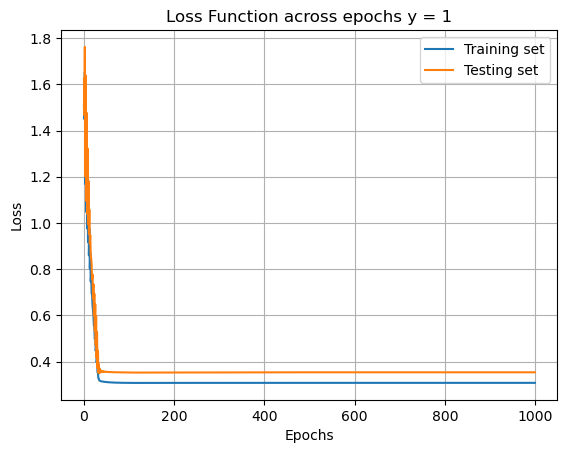

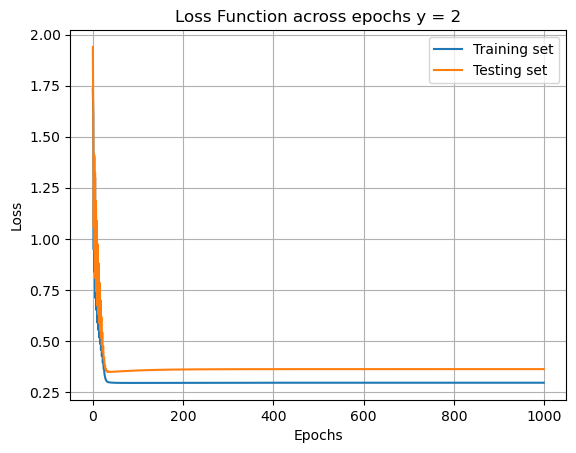

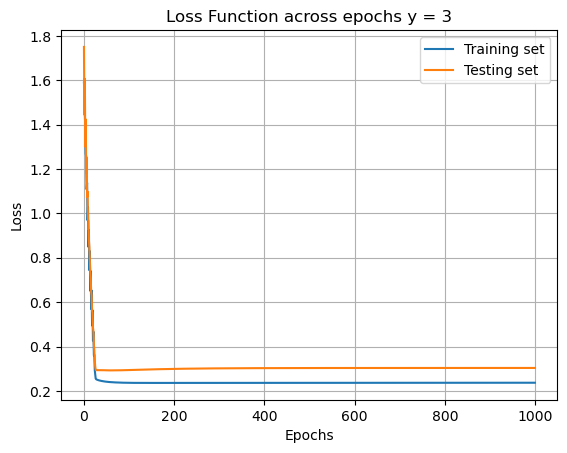

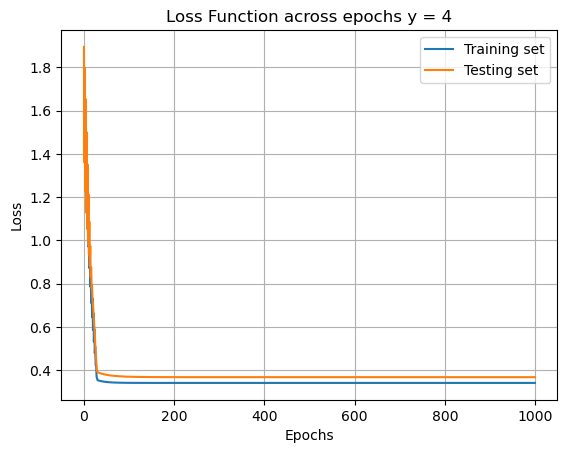

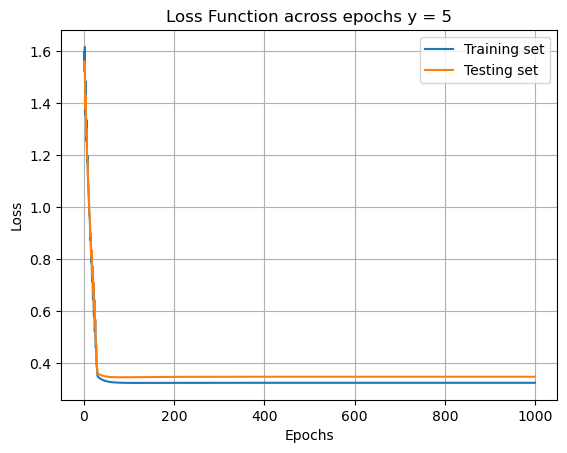

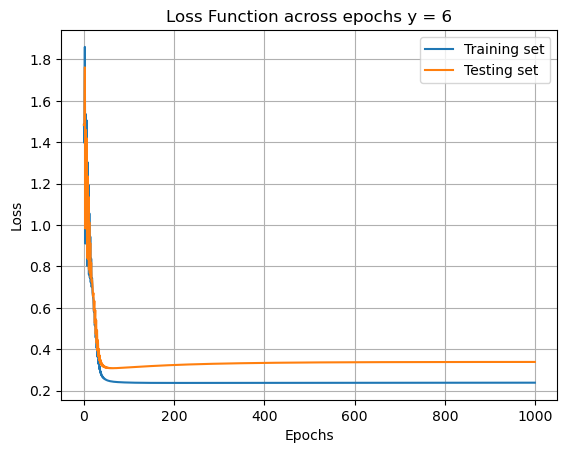

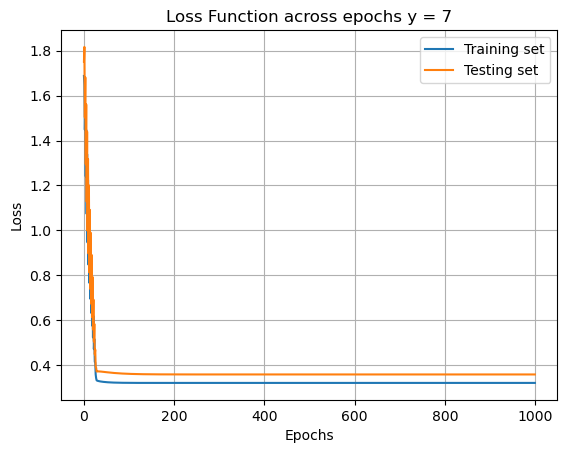

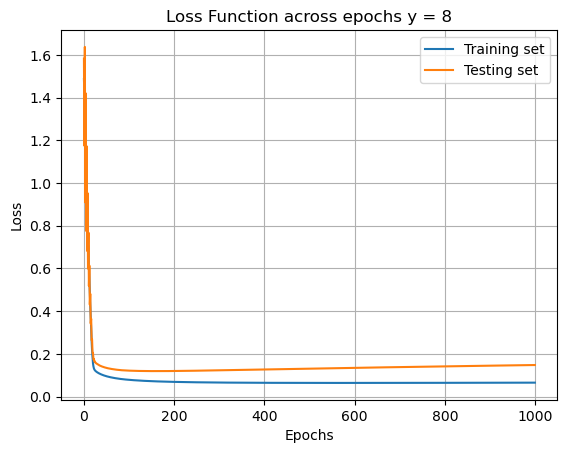

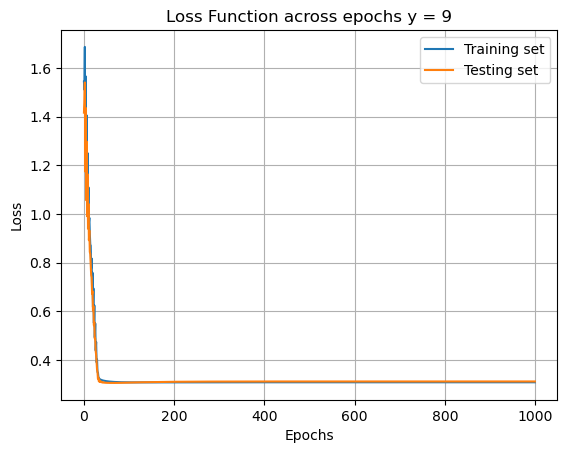

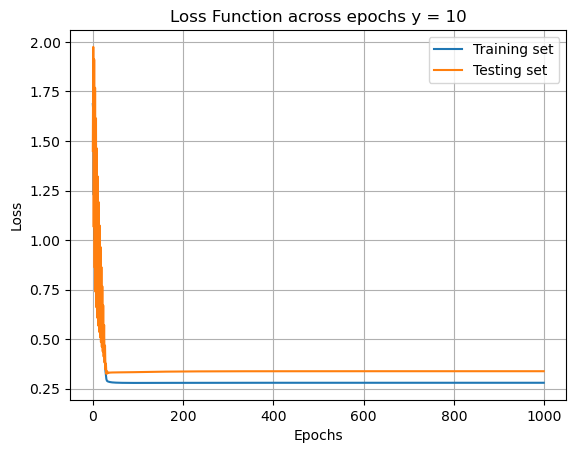

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# estimators
lr_estimator = estimators['lr'][-1].estimator

# params
sss =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 10)
scaler = StandardScaler()
pca = PCA(n_components = 16, random_state = 23)
transformer = make_pipeline(scaler, pca)

# iterating across unique "y" values
for class_target in np.unique(y):
    # selecting target class
    Y = np.where(y.copy() == class_target, 1, 0)
    
    # spliting matrix into training and test set
    train_index, test_index = list(sss.split(X, Y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # transform variables
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    
    # fitting estimators and getting losses
    lr_estimator.fit(X_train, y_train)
    loss_train, loss_test = lr_estimator.compute_loss(X_train, y_train, X_test, y_test)
    
    plt.plot(loss_train, label = 'Training set')
    plt.plot(loss_test, label = 'Testing set')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Function across epochs y = {class_target}')
    plt.legend()
    plt.grid()
    plt.show()